In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import matplotlib.patches as patches

In [10]:
X_train = joblib.load("Data/Xtrain1.pkl")
Y_train = np.load('Data/Ytrain1.npy')
print(X_train.shape)
print(Y_train.shape)

patient_ids = X_train["Patient_Id"].values
X_train = np.vstack(X_train["Skeleton_Features"].values)

connections = {
    'trunk': [(11, 12), (11, 23), (12, 24), (23, 24)],
    'right_arm': [(12, 14), (14, 16), (22, 16), (20, 16), (20, 18), (18, 16)],
    'left_arm': [(11, 13), (13, 15), (21, 15), (15, 19), (19, 17), (17, 15)],
    'right_leg': [(23, 25), (25, 27), (27, 31), (31, 29), (29, 27)],
    'left_leg': [(24, 26), (26, 28), (28, 30), (30, 32), (28, 32)]
}

colors = {
    'trunk': 'blue',
    'right_arm': 'red',
    'left_arm': 'green',
    'right_leg': 'orange',
    'left_leg': 'purple'
}

head_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

(700, 2)
(700,)


Original shape: (700, 132), with angles: (700, 133)
Train shape: (490, 133), Test shape: (210, 133)


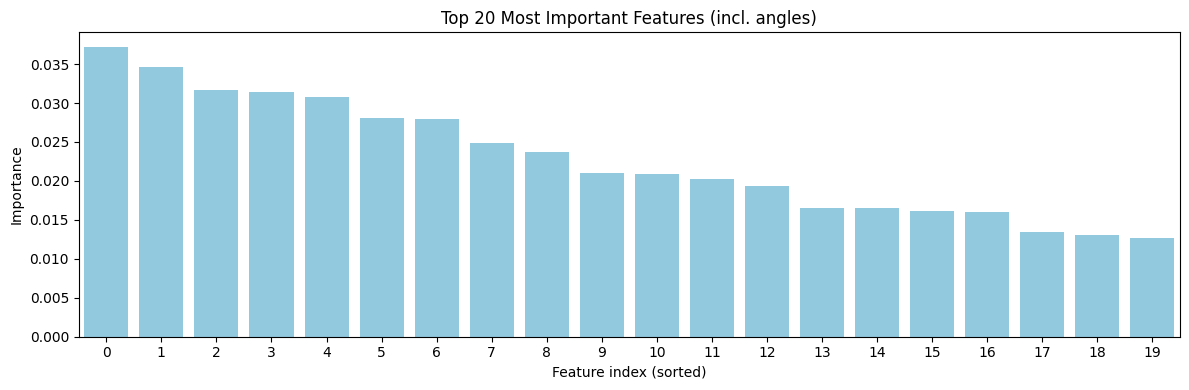

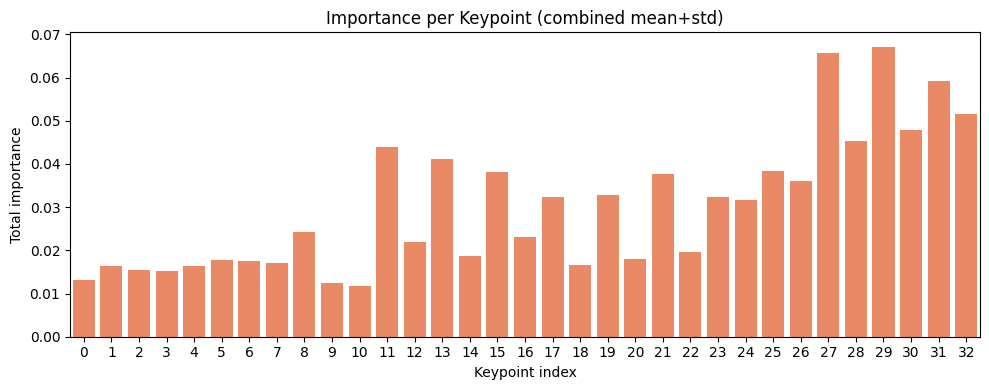

Best CV macro-F1: 0.9679
Best params: {'clf__alpha': 0.001, 'clf__batch_size': 32, 'clf__hidden_layer_sizes': (128, 64), 'clf__learning_rate_init': 0.01}
Test macro-F1: 0.9762
              precision    recall  f1-score   support

         0.0      1.000     0.929     0.963        84
         1.0      0.933     1.000     0.966        84
         2.0      1.000     1.000     1.000        42

    accuracy                          0.971       210
   macro avg      0.978     0.976     0.976       210
weighted avg      0.973     0.971     0.971       210



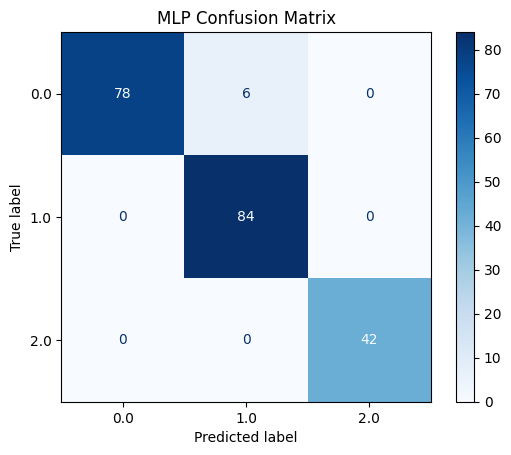

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

# --- 🔧 Função para calcular ângulo entre 3 pontos ---
def calculate_angle(a, b, c):
    """Calcula o ângulo (em graus) formado por três pontos 2D: a-b-c"""
    ba = a - b
    bc = c - b
    cos_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-8)
    angle = np.degrees(np.arccos(np.clip(cos_angle, -1.0, 1.0)))
    return angle

# --- 🧩 Função para extrair ângulos a partir das 33 keypoints ---
def compute_joint_angles(X):
    n_samples = X.shape[0]
    angles = np.zeros((n_samples, 1))  # vamos começar só com 1 ângulo
    for i in range(n_samples):
        sample = X[i]
        mean_coords = sample[:66]  # 33*2
        x = mean_coords[0::2]
        y = mean_coords[1::2]
        points = np.stack([x, y], axis=1)
        # ângulo do braço direito (12-14-16)
        angles[i, 0] = calculate_angle(points[12], points[14], points[16])
    return angles

# --- 0️⃣ Calcular ângulos e adicionar como novas features ---
angles = compute_joint_angles(X_train)
X_with_angles = np.hstack([X_train, angles])
print(f"Original shape: {X_train.shape}, with angles: {X_with_angles.shape}")

# --- 1️⃣ Split data ---
X_train_1, X_test, Y_train_1, Y_test = train_test_split(
    X_with_angles, Y_train, test_size=0.3, random_state=42, stratify=Y_train
)

print(f"Train shape: {X_train_1.shape}, Test shape: {X_test.shape}")

# --- 2️⃣ Baseline RandomForest ---
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train_1, Y_train_1)

# --- 3️⃣ Feature importances ---
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# --- Plot top 20 features ---
plt.figure(figsize=(12,4))
sns.barplot(x=np.arange(20), y=importances[indices[:20]], color="skyblue")
plt.title("Top 20 Most Important Features (incl. angles)")
plt.xlabel("Feature index (sorted)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# --- 4️⃣ Aggregate importance by keypoint (4 features por keypoint) ---
key_importances = []
for k in range(33):
    feat_idx = [2*k, 2*k+1, 66 + 2*k, 66 + 2*k + 1]
    key_importances.append(importances[feat_idx].sum() if max(feat_idx) < len(importances) else 0)

plt.figure(figsize=(10,4))
sns.barplot(x=np.arange(33), y=key_importances, color="coral")
plt.title("Importance per Keypoint (combined mean+std)")
plt.xlabel("Keypoint index")
plt.ylabel("Total importance")
plt.tight_layout()
plt.show()

# --- 5️⃣ Select top 15 most important keypoints ---
important_keypoints = np.argsort(key_importances)[-15:]
selected_features = []
for k in important_keypoints:
    selected_features += [2*k, 2*k+1, 66 + 2*k, 66 + 2*k + 1]

# inclui também o novo ângulo
selected_features += [X_with_angles.shape[1] - 1]

X_train_sel = X_train_1[:, selected_features]
X_test_sel = X_test[:, selected_features]

# Uses your already-prepared X_train_sel, Y_train_1, X_test_sel, Y_test

mlp_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', MLPClassifier(
        activation='relu',
        solver='adam',
        early_stopping=True,
        n_iter_no_change=10,
        max_iter=400,
        random_state=42,
        verbose=False
    ))
])

param_grid = {
    'clf__hidden_layer_sizes': [(64,), (128,), (64,32), (128,64)],
    'clf__alpha': [1e-5, 1e-4, 1e-3],
    'clf__learning_rate_init': [1e-3, 3e-3, 1e-2],
    'clf__batch_size': [32, 64, 128]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(
    estimator=mlp_pipe,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0
)

gs.fit(X_train_sel, Y_train_1)

print(f"Best CV macro-F1: {gs.best_score_:.4f}")
print("Best params:", gs.best_params_)

# Test evaluation
y_pred = gs.predict(X_test_sel)
test_f1 = f1_score(Y_test, y_pred, average='macro')
print(f"Test macro-F1: {test_f1:.4f}")
print(classification_report(Y_test, y_pred, digits=3))

# Confusion matrix
classes = np.unique(Y_test)
cm = confusion_matrix(Y_test, y_pred, labels=classes)
ConfusionMatrixDisplay(cm, display_labels=classes).plot(cmap="Blues", values_format="d")
plt.title("MLP Confusion Matrix")
plt.show()